# Can we recover MNIST clusters from mixed data?

As we saw in [our analysis of the mixed images](AnalyzeMixedImages.ipynb), simply embedding the image data using a standard algorithm does not help to reveal the individual digit categories.  If a scenario where only the mixed data were provided, it would be much harder to determine that there are distinct digit classes underlying this data.

We would like to explore possible techniques for extracting and visualizing the MNIST manifold hidden within this mixed data.

In [1]:
%%capture

import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import DataUtils as DU

import cache_magic # pip install ipython-cache

## Setup Code

In the cells below, we:

1. load the datasets,
2. synthesized the mixed data,
3. compute covariance matrices, and
4. compute the principal components.

The datasets are labeled as follows:

* `A` -- "pure" MNIST data
* `B` -- "noise" grass data
* `C` -- "mixed" data (80% grass; 20% MNIST)
* `D` -- second grass data set, independent samples with same distribution as `B`

In a realistic setting, we would only be given `C` and `D`.

Looking at the data and covariance structure of `A` and `B` can be instructive for devising a technique to "denoise" `C`,
however using either of these in the solution is "cheating".


In [2]:
Aimg, Alab = DU.load_data("data/mnist_70000.h5")
Bimg, Blab = DU.load_data("data/grass2.hdf5")
Cimg = Aimg * 0.2 + Bimg * 0.8
Dimg, Dlab = DU.load_data("data/grass1.hdf5")

In [3]:
Agrouped = np.hstack([np.arange(70000)[Alab==i][:10] for i in range(10)])
Bgrouped = np.hstack([np.arange(70000)[Alab==i][:10] for i in range(10)])

In [4]:
A, Abar, Acov = DU.normalize_image_data(Aimg)
B, Bbar, Bcov = DU.normalize_image_data(Bimg)
C, Cbar, Ccov = DU.normalize_image_data(Cimg)
D, Dbar, Dcov = DU.normalize_image_data(Dimg)

In [5]:
Au, As, Avt = np.linalg.svd(Acov)
Bu, Bs, Bvt = np.linalg.svd(Bcov)
Cu, Cs, Cvt = np.linalg.svd(Ccov)
Du, Ds, Dvt = np.linalg.svd(Dcov)

## Experiment 1: Reuse the MNIST PCs (Cheating!)

Let's start by imagining that we already know what the MNIST digits are supposed to look like.  If we knew this, we could try to massage the mixed data by projecting it into the first 50-100 PCs of MNIST (dataset `A`).  This might help to uncover the signal we're looking for.

As a reminder, here are the first 10 PCs of MNIST:

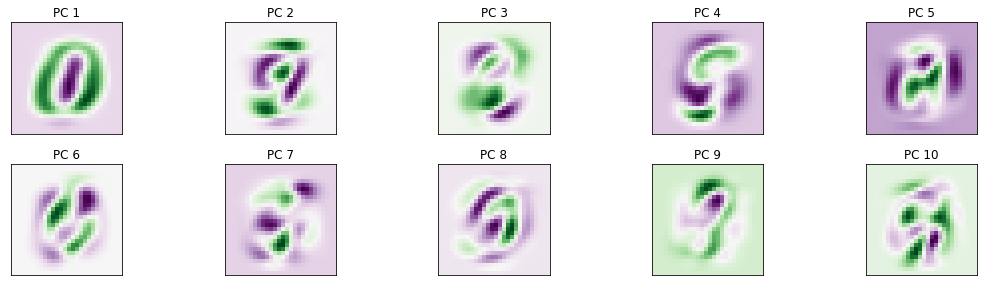

In [6]:
DU.show_pcs(Au, 10)

And this is the result of projecting the mixed images using the first 100 PCs of MNIST:

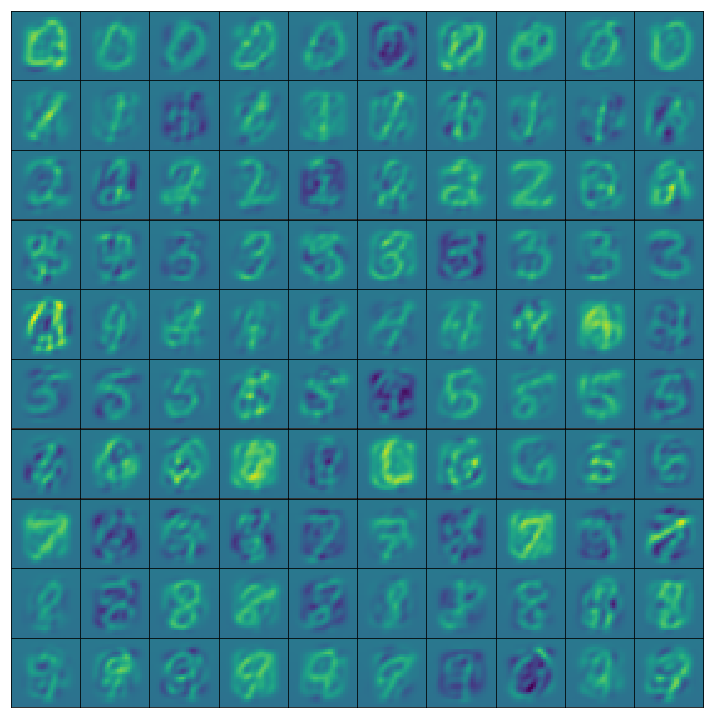

In [7]:
DU.show_data(DU.X_to_img(C[Agrouped] @ Au[:,0:50] @ Au[:,0:50].T, Cbar), cols=10)

**Observations:**

1. Some digit forms are visible, however they are not especially clear.
2. There is a lot of visual clutter around each digit where portions of the grass texture have projected onto the principal components of the digits.
3. The average background intensity in the digit area is not uniform.

This clutter and nonuniform intensity are likely to interfere with detection of the manifold.

We can confirm that projecting into this subspace only does a limited amount of work in revealing the MNIST manifold by embedding with UMAP:

loading cached value for variable 'umap_mixed_mnist_pca100'. Time since pickling  2 days, 1:12:23.385875


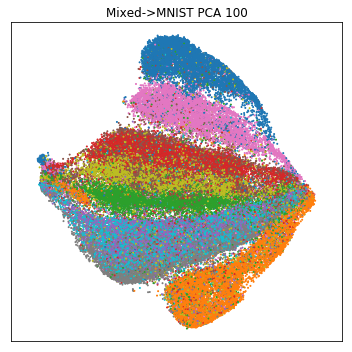

In [8]:
%cache umap_mixed_mnist_pca100 = DU.umap_embedding(C @ Au[:,0:100])

DU.show_embeddings([umap_mixed_mnist_pca100], titles=["Mixed->MNIST PCA 100"], labels=Alab)

**Observations:**

1. The embedding does reveal some spatial coherence amongst the digits, but
2. these regions are elongated and have overlapping boundaries.

This suggests that there are some very strong directions remaining in the data which are not useful for identifying digits.

If we can eliminate these directions from the data, we may be able to improve the image.

## Experiment 2: Remove "Background" PCs from Data

From [our earlier investigation of the grass dataset](AnalyzeGrassData.ipynb), we know that the first few PCs explain half of the variance.

Perhaps we can remove these PCs from the mixed data to obtain a "better" result?

Since grass data `D` has the same distribution as `B`, we should be able to do this by projecting the mixed data into the null space of `PCA(D, k)`.

The PCs of `D` are virtually identical to those of `B`, and look like this:

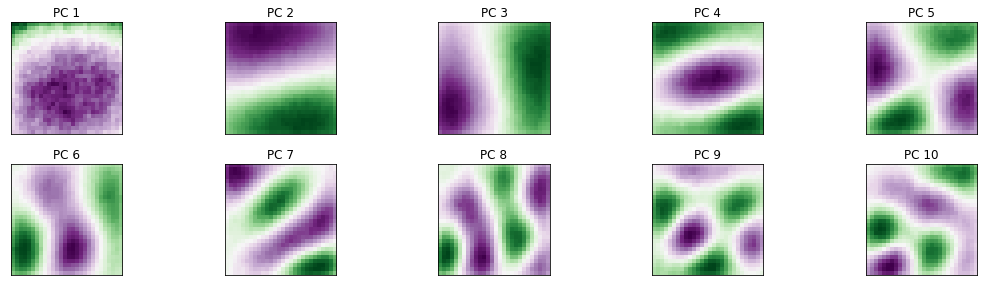

In [9]:
DU.show_pcs(Du, 10)

**Observations:**

* The first three PC correspond (roughly) to:

  1. average image intensity
  2. vertical gradient
  3. horizontal gradient


* PC 4 (and beyond) are more suspicious because these focus on more specific areas and could interfere with digit recognition.

We will start conservatively, by removing only the first three principal components.

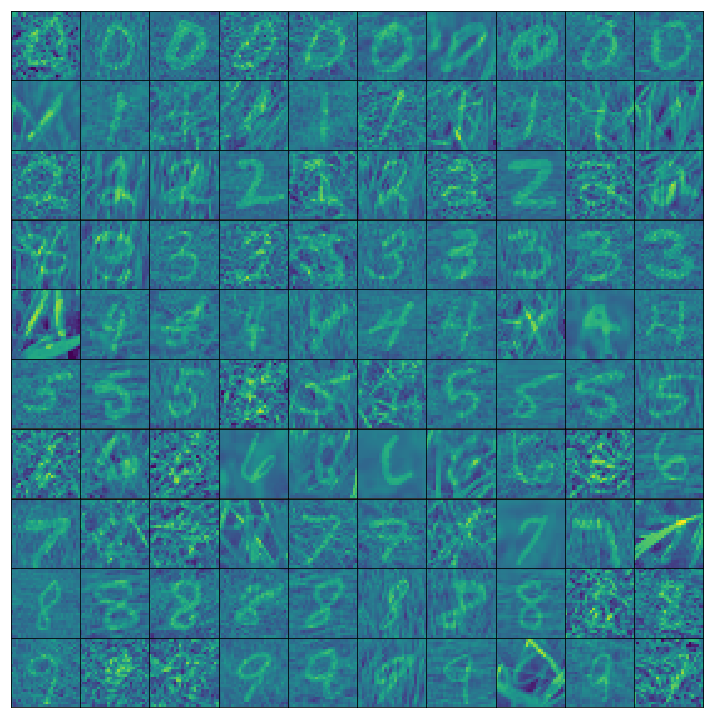

In [10]:
DU.show_data(DU.X_to_img(C[Agrouped] @ Du[:,3:] @ Du[:,3:].T, Cbar), cols=10)

**Observations:**

1. Removing the first few components of `D` has controlled for variations in image intensity and simple gradients.
2. Most digits still appear to be on a strong textured background.
3. None of the first 10 grass PCs are likely to remove this strong background, as they are all too coarse.

Strong textures are likely to interfere with our ability to detect the manifold.

We examine the umap embedding next:

loading cached value for variable 'umap_mixed_grass_sub3'. Time since pickling  1 day, 11:17:32.436716


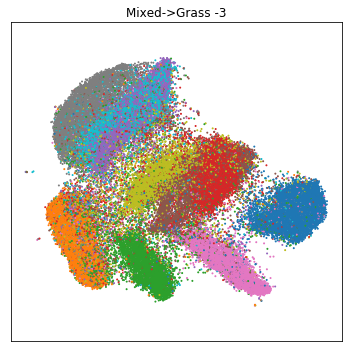

In [11]:
%cache umap_mixed_grass_sub3 = DU.umap_embedding(C @ Du[:,3:])

DU.show_embeddings([umap_mixed_grass_sub3], titles=["Mixed->Grass -3"], labels=Alab)

And here, we see a much more promising sign.

Despite the textured background, the shear preponderance of data has allowed us to uncover a rough, noisy version of the MNIST manifold.

Can we do better?

## Experiment 3: Remove background and reduce dimension

Continuing from experiment 2, what if we were to remove the background and reduce the dimension further via PCA?

Here, we build a covariance matrix from the projected data in Experiment 2 and compute the SVD:

In [12]:
CX3 = C @ Du[:,3:] @ Du[:,3:].T
CX3cov = CX3.T @ CX3
CX3u, CX3s, CX3vt = np.linalg.svd(CX3cov)

We can examine the first 10 principal components of this data.

### PCs 1-10 of Reduced Data

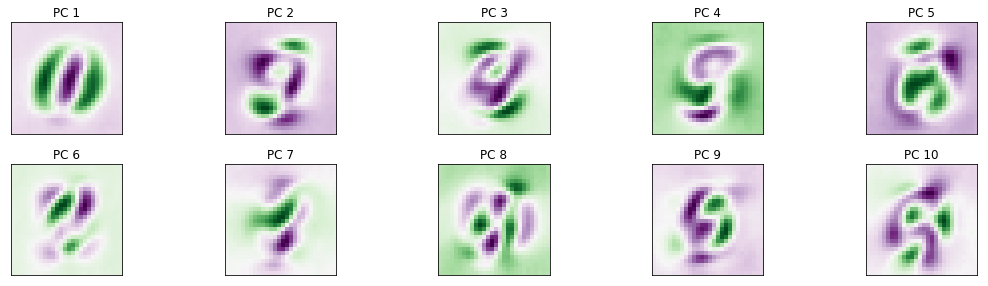

In [13]:
DU.show_pcs(CX3u, 10)

### PC 1-10 of MNIST

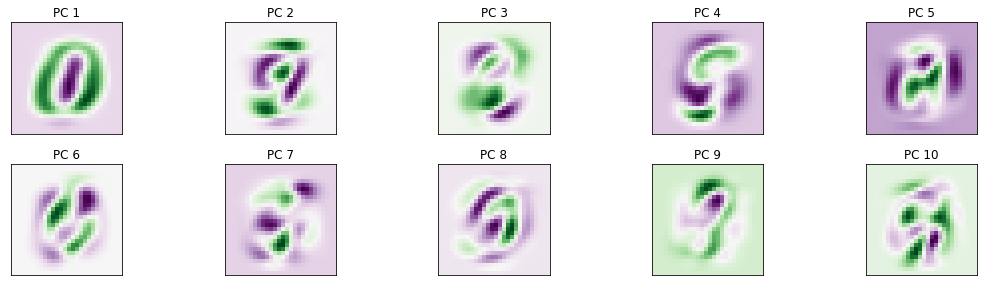

In [14]:
DU.show_pcs(Au, 10)

**Observations:**

1. PCs 1-5 are very similar to those in MNIST.
2. Subsequent PCs differ somewhat more.

Next, we examine the images when reduced to the first 50 PCs:

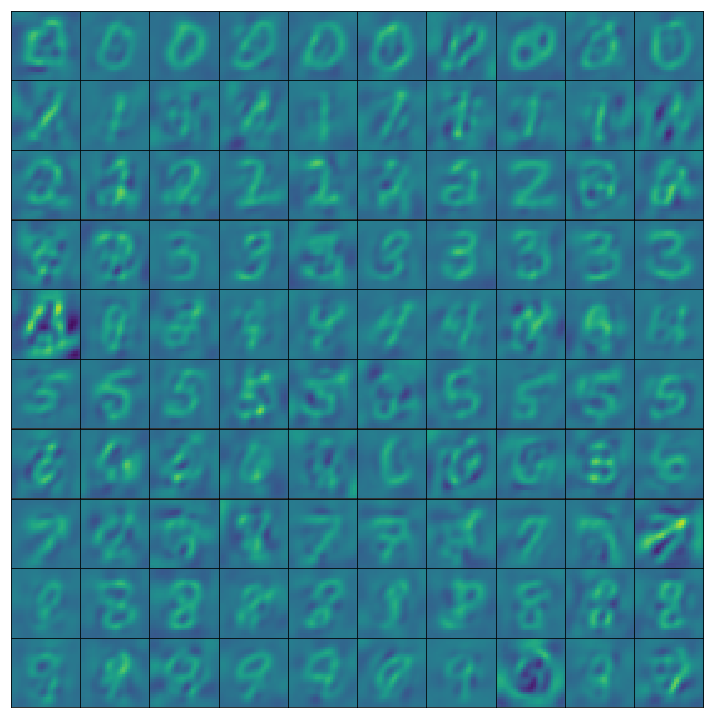

In [15]:
DU.show_data(DU.X_to_img(CX3[Agrouped] @ CX3u[:,:50] @ CX3u[:,:50].T, Cbar), cols=10)

**Observations**

1. Limiting the data to 50 PCA dimensions has resulted in blurrier images.
2. This has consequentially reduced the impact of sharp background textures.

Next, we examine the UMAP embedding:

loading cached value for variable 'umap_mixed_grass_sub3_pca50'. Time since pickling  1 day, 11:04:23.172209


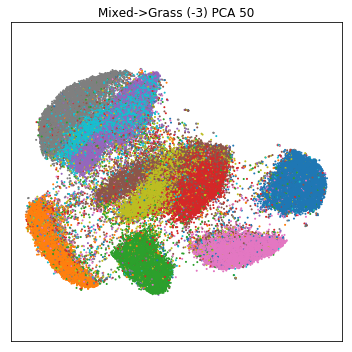

In [16]:
%cache umap_mixed_grass_sub3_pca50 = DU.umap_embedding(CX3 @ CX3u[:,:50])

DU.show_embeddings([umap_mixed_grass_sub3_pca50], titles=["Mixed->Grass (-3) PCA 50"], labels=Alab)

**Observations**

1. Some clusters are now much better separated from the group.
2. Clutter has been somewhat reduced.

**Can we do better?**

## Experiment 4: Contrastive PCA

A recent paper in Nature Communications describes a technique called [Contrastive PCA](https://www.nature.com/articles/s41467-018-04608-8).  It presents a simple mechanism for discovering a subspace of "contrastive" principal components which explain as much of the signal variance and as little of the background variance as possible.

In Contrastive PCA, we compute a new covariance-like matrix as the difference between the mixed signal covariance and the background covariance:

$$ \Sigma^* = \Sigma_{X} - \alpha \Sigma_{Y} $$

where:

* $\Sigma^*$ is the contrastive "covariance" matrix,
* $\Sigma_{X}$ is the covariance of the mixed signal,
* $\Sigma_{Y}$ is the covariance of a "background" sample, and
* $\alpha$ is a parameter which allows exploring the frontier of contrasting principal components.

This leaves us with the task of determining a good value for the parameter $\alpha$.

We know that when:

* $\alpha = 0$, $\Sigma^* = \Sigma_{X}$ (i.e. same as PCA on the mixed signal)
* $\alpha = \inf$, $\Sigma^* \propto \Sigma_{Y}$ (i.e. same components as the background signal)

However, based on our mixing model, we can also determine another value for $\alpha$, as follows.

### Solving for $\alpha$

Given two distributions, $S$ and $T$, where:

* $\bar{S} = \bar{T} = 0$ (i.e. zero mean), and
* $S^T T = T^T S = 0$ (i.e. independence),

then we can write a mixture $R$ as:

$$ R = \gamma S + (1 - \gamma) T $$

We can write the covariance of $R$ as:

$$ \Sigma_R = R^T R = (\gamma S + (1 - \gamma) T)^T (\gamma S + (1 - \gamma) T) $$

Expanding, we get:

$$ \Sigma_R = \gamma^2 S^T S + (1 - \gamma) \gamma T^T S + \gamma (1 - \gamma) S^T T + (1 - \gamma)^2 T^T T $$

Assuming independence of $S$ and $T$, we can drop the cross terms to get:

$$ \Sigma_R = \gamma^2 S^T S + (1 - \gamma)^2 T^T T $$

Rewriting, $\Sigma_S = S^T S$ and $\Sigma_T = T^T T$, we get:

$$ \Sigma_R = \gamma^2 \Sigma_S + (1 - \gamma)^2 \Sigma_T $$

Solving for $\Sigma_S$ gives:

$$ \Sigma_S = {1 \over \gamma^2} (\Sigma_R - (1 - \gamma)^2 \Sigma_T) $$

Ignoring the coefficient ${1 \over \gamma^2}$, we see:

$$ \Sigma_S \propto \Sigma_R - (1 - \gamma)^2 \Sigma_T $$

Notice that this has the same form as the Contrastive PCA covariance:

$$ \Sigma^* = \Sigma_{X} - \alpha \Sigma_{Y} $$

By equating the right hand sides of these equations, we get that:

$$ \alpha = (1 - \gamma)^2 $$

### Value of $\alpha$

Since we used $\gamma = 0.2$ in our mixing model, we see that $\alpha = 0.64$ is the corresponding parameter for contrastive PCA.

We know that when:

* $\alpha = 0$, $\Sigma^* = \Sigma_{X}$ (i.e. same as PCA on the mixed signal)
* $\alpha = (1 - \gamma)^2$, $\Sigma^* \propto \Sigma{X}$ (i.e. same components as the desired signal)
* $\alpha = \inf$, $\Sigma^* \propto \Sigma_{Y}$ (i.e. same components as the background signal)

So, $\alpha$ gives us a way to move between the components of the mixed signal, the foreground signal, and the background signal.

Going forward, we'll use $\alpha = 0.64$.


In [17]:
alpha = 0.64
Xcov = Ccov - alpha * Dcov
Xu, Xs, Xvt = np.linalg.svd(Xcov)

### Contrastive PCs

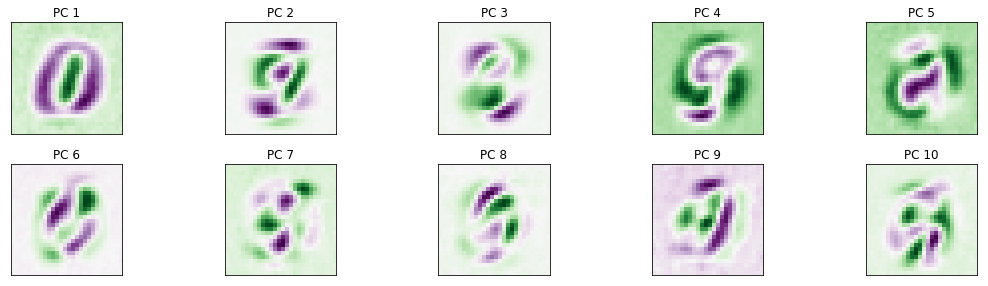

In [18]:
DU.show_pcs(Xu, 10)

### MNIST PCs

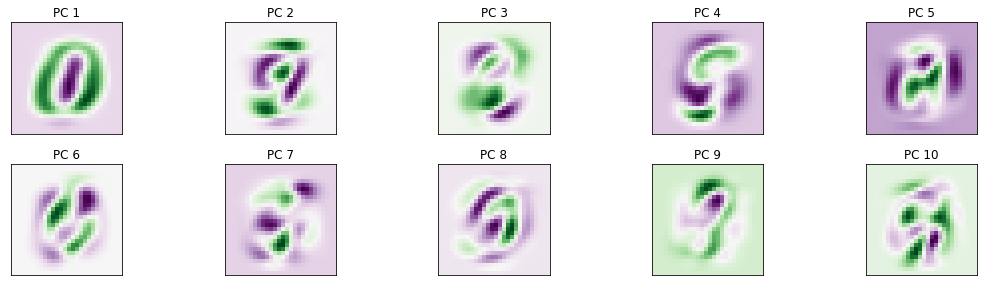

In [19]:
DU.show_pcs(Au, 10)

**Observations:**

1. The first 10 contrastive PCs are almost identical to the MNIST PCs, up to a sign flip.

This confirms that we are able to recover the MNIST PCs from the mixed signal without (cheating).

*(A small caveat is that we used the knowledge that $\gamma = 0.2$ to derive the value for $\alpha$.  However, it may be possible to overcome this via optimization.)*


## Experiment 5: Use Contrastive PCs

Let's try projecting the mixed signal into contrastive PC space to see if we can better isolate the MNIST digit information.

Here are the digit images projected using the first 50 contrastive components:

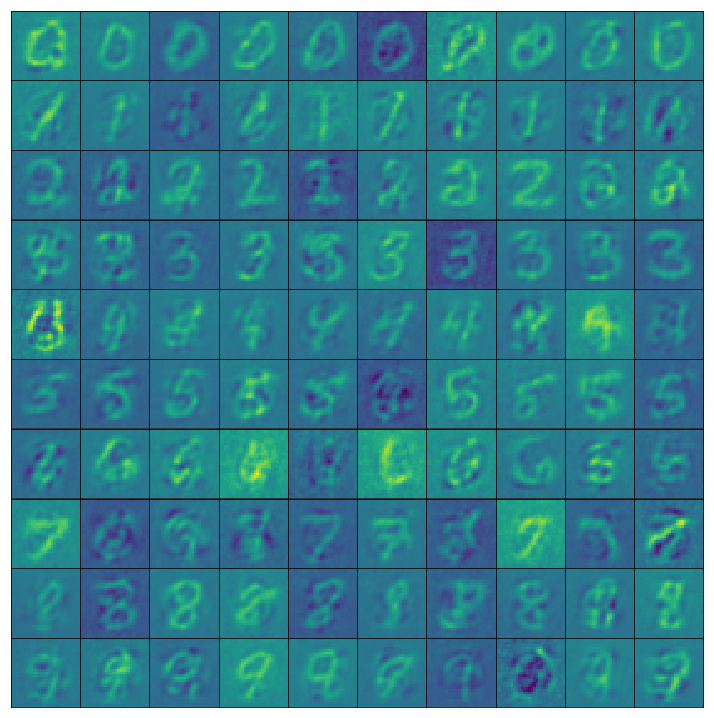

In [20]:
DU.show_data(DU.X_to_img(C[Agrouped] @ Xu[:,:50] @ Xu[:,:50].T, Cbar), cols=10)

**Observations:**

1. Image backgrounds vary in average intensity.
2. There are some lines surrounding the digits.
3. The images are virtually identical to what we produced when we "cheated" and used the MNIST (i.e. pure signal) principal components. 

Here is the UMAP embedding when projecting the mixed data using the first 50 contrastive PCs:

loading cached value for variable 'umap_mixed_cpca50'. Time since pickling  1:18:48.949121


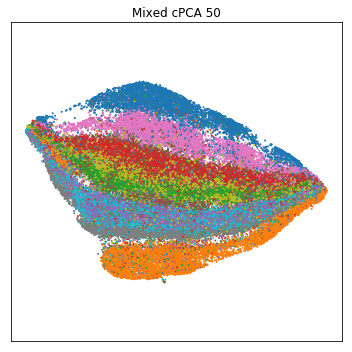

In [21]:
%cache umap_mixed_cpca50 = DU.umap_embedding(C @ Xu[:,:50])

DU.show_embeddings([umap_mixed_cpca50], titles=["Mixed cPCA 50"], labels=Alab)

**Observations:**

1. Digit categories appear as long horizontal bands with overlapping edges.
2. This embedding is virtually identical to what we obtained when using the MNIST PCs.

## Experiment 6: Remove Background PCs, then use Contrastive PCs



In [22]:
CT2 = C @ (Du[:,3:] @ Du[:,3:].T @ Xu[:,:50])

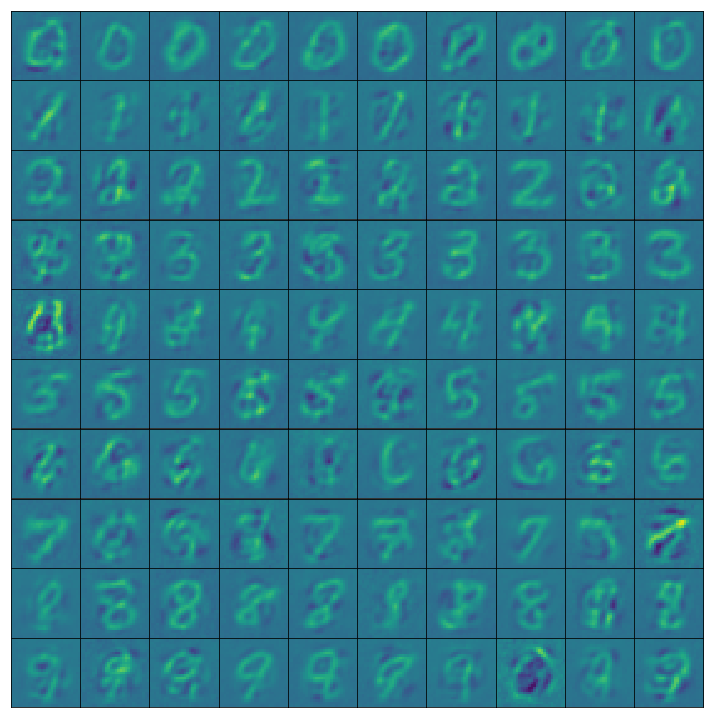

In [23]:
DU.show_data(DU.X_to_img(CT2[Agrouped] @ Xu[:,:50].T, Cbar), cols=10)

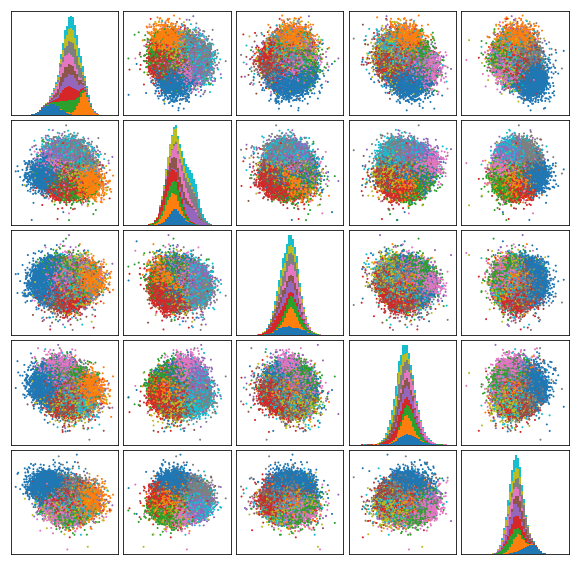

In [24]:
DU.show_splom(CT2[:,0:5], labels=Alab)

loading cached value for variable 'umap_mixed_grass_sub3_cpca50'. Time since pickling  0:10:06.079865


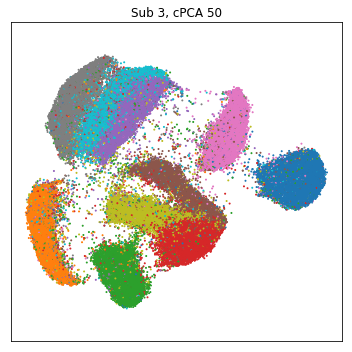

In [25]:
%cache umap_mixed_grass_sub3_cpca50 = DU.umap_embedding(CT2)

DU.show_embeddings([umap_mixed_grass_sub3_cpca50], titles=["Sub 3, cPCA 50"], labels=Alab)

In [26]:
d1vals = list(range(6))
d2vals = [5,10,20,50,100]
def build_CTvals():
    CTvals = {}
    for d1 in d1vals:
        for d2 in d2vals:
            CT = C @ (Du[:,d1:] @ Du[:,d1:].T @ Xu[:,:d2])
            CTvals[d1, d2] = CT
    return CTvals

%cache CTvals = build_CTvals()

loading cached value for variable 'CTvals'. Time since pickling  2 days, 17:00:48.679481


In [27]:
%cache CT_umap = {(d1,d2): DU.umap_embedding(x) for (d1, d2), x in CTvals.items()}

loading cached value for variable 'CT_umap'. Time since pickling  2 days, 16:00:44.068175


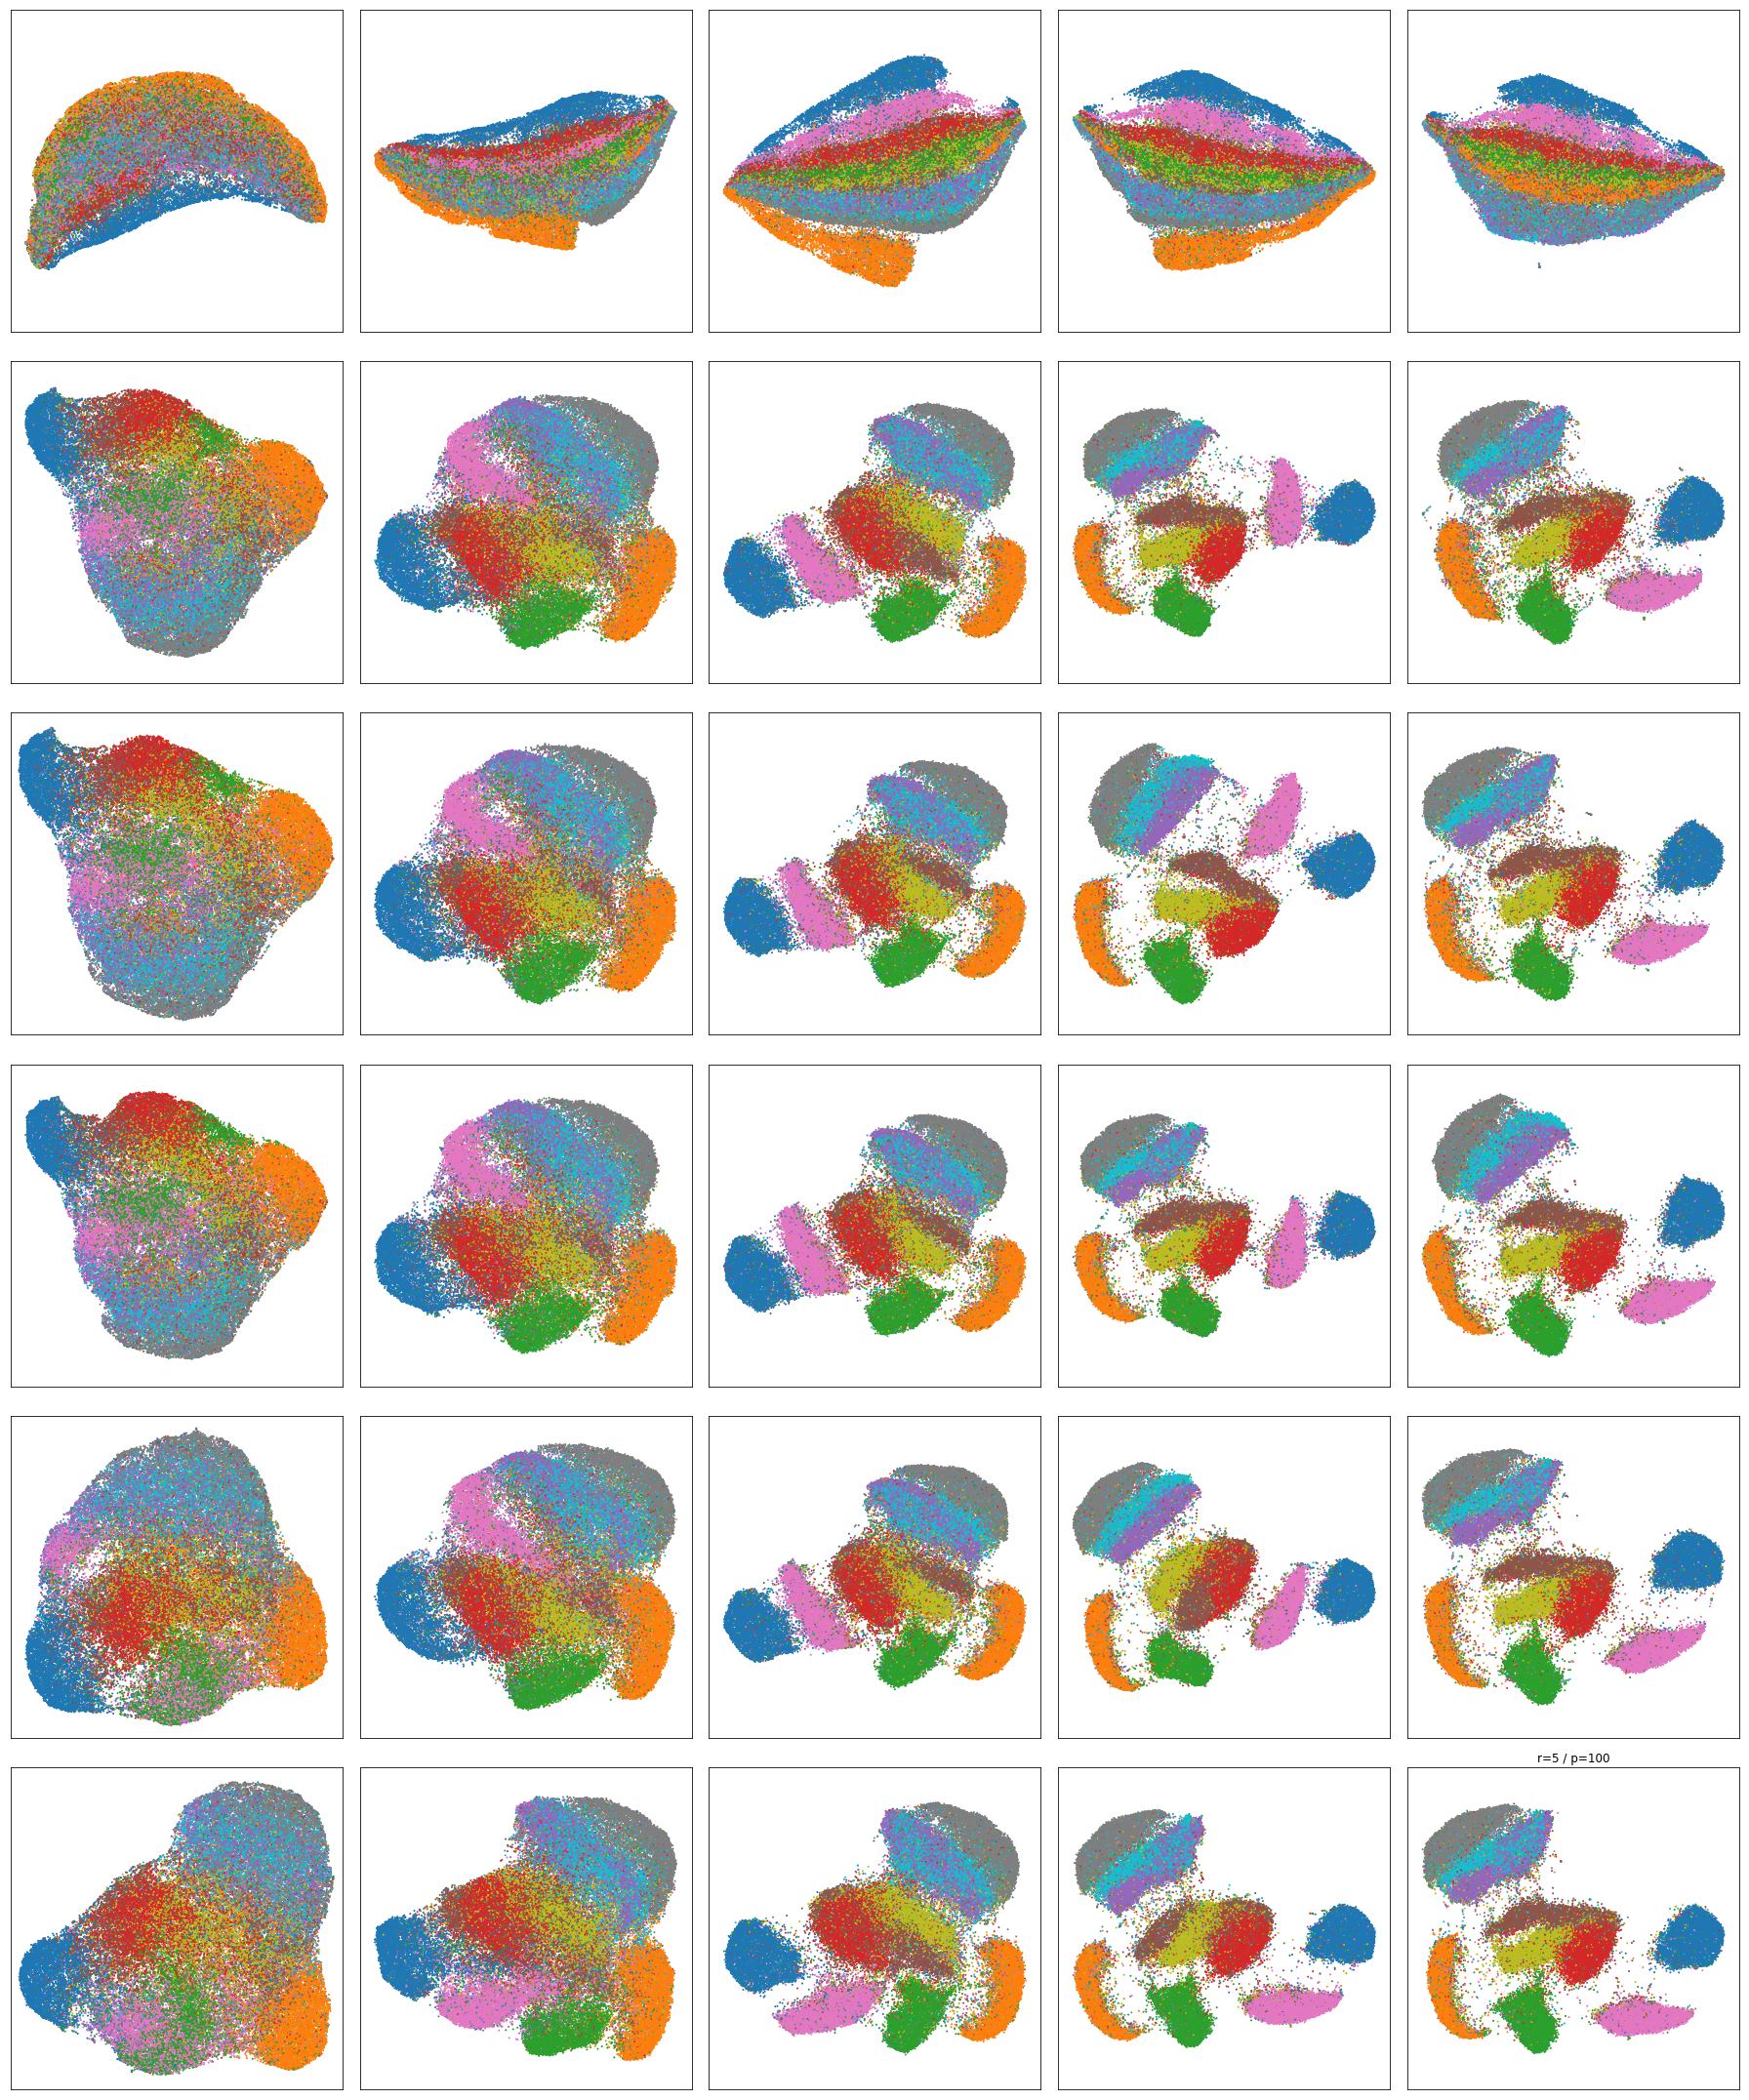

In [28]:
fig, axes = plt.subplots(nrows=len(d1vals), ncols=len(d2vals), figsize=(25,30))
for (d1, d2), x in CT_umap.items():
    i = d1vals.index(d1)
    j = d2vals.index(d2)
    plt.title("r={} / p={}".format(d1, d2))
    axes[i,j].scatter(x[:,0], x[:,1], c=Alab, cmap='tab10', s=1)
    axes[i,j].xaxis.set_visible(False)
    axes[i,j].yaxis.set_visible(False)
    axes[i,j].axis('equal')
plt.tight_layout()

## Experiment 7: Use orthogonal basis after removing background

In [29]:
tt = Du[:,3:] @ Du[:,3:].T
Fcov = tt @ Ccov @ tt.T
Fu, Fs, Fvt = np.linalg.svd(Fcov)

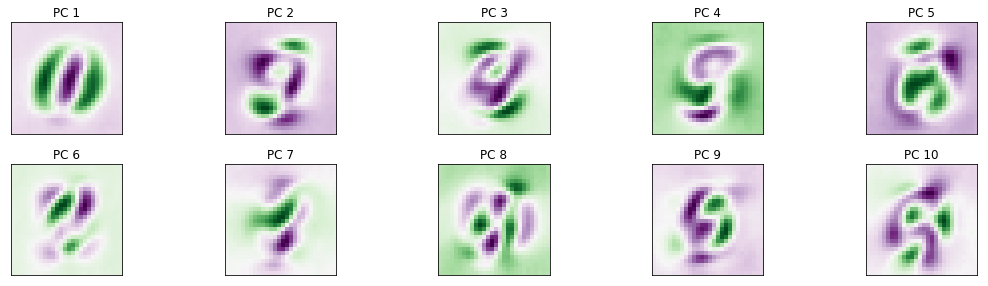

In [30]:
DU.show_pcs(Fu, 10)

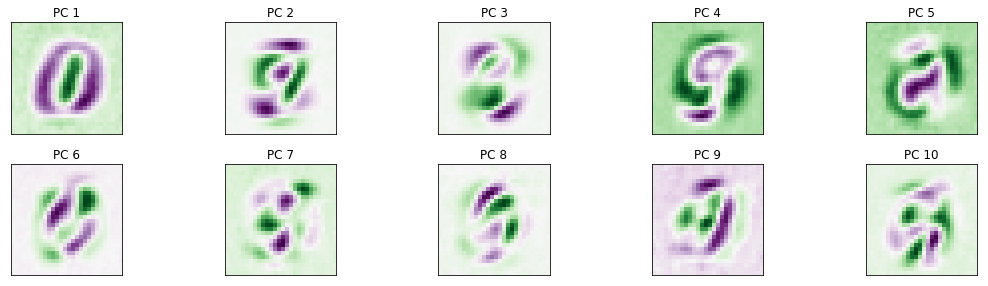

In [31]:
DU.show_pcs(Xu, 10)

loading cached value for variable 'umap_mixed_grass_sub3_ortho_cpca50'. Time since pickling  0:06:32.652529


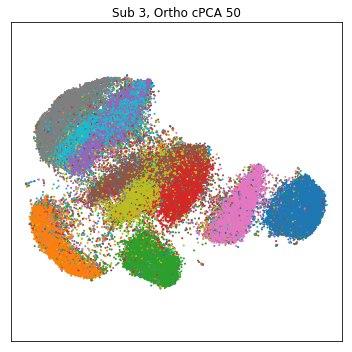

In [32]:
%cache umap_mixed_grass_sub3_ortho_cpca50 = DU.umap_embedding(C @ Fu[:,:50])

DU.show_embeddings([umap_mixed_grass_sub3_ortho_cpca50], ["Sub 3, Ortho cPCA 50"], labels=Alab)

## Experiment 8: Determining $\alpha$ numerically

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arccos
  import sys


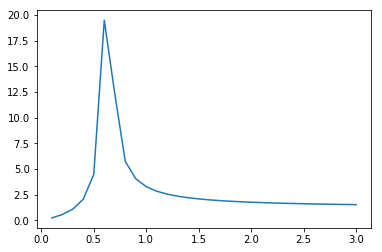

In [34]:
alphas = np.linspace(0.0, 3.0, 31)
def getpc1(C):
    u, s, vt = np.linalg.svd(C)
    return u[:,0]
    
pc1 = getpc1(Ccov)
angles = [np.arccos(pc1 @ getpc1(Ccov - a * Dcov)) * (180.0/np.pi) for a in alphas]
plt.plot(alphas, angles)

In [35]:
%cache